### Installs for google colab

In [ ]:
# installing dependencies
# !git clone --recursive https://github.com/CPJKU/madmom.git
# %cd madmom
# !pip install -e .
%pip install https://github.com/CPJKU/beat_this/archive/main.zip
%pip install mir-eval pytorch-lightning torchaudio pedalboard torchcodec librosa

# from madmom import features

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

### Imports + variables

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

from tqdm import tqdm
from pathlib import Path
from librosa import clicks
from IPython.display import Audio

import torch
import torchaudio
import torchaudio.transforms as T
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from beat_this.dataset import BeatDataModule
from beat_this.model.pl_module import PLBeatThis

from pedalboard import PitchShift
from pedalboard._pedalboard import Pedalboard


args = {
    "name": "fineTuned",
    "max_epochs": 30,
    "val_frequency": 8, # validate every N epochs
    "lr": 0.0004,
    "warmup_steps": 100,
    "loss": "shift_tolerant_weighted_bce", # other options are "fast_shift_tolerant_weighted_bce", "weighted_bce", "bce"
    "eval_trim_beats": 5, # skip the first given seconds per piece in evaluating
    "dbn": False,
    "tempo_augmentation": False,
    "pitch_augmentation": False,
    "mask_augmentation": True,
    "sum_head": True,
    "gpu": 0,
    "length_based_oversampling_factor": 0.5, # usually 0.65
    "compile": ["frontend", "transformer_blocks", "task_heads"],
    "n_layers": 6,
    "transformer_dim": 512,
    "frontend_dropout": 0.1,
    "transformer_dropout": 0.2,
    "weight_decay": 0.01,
    "logger": "none",
    "num_workers": 8,
    "n_heads": 16,
    "fps": 50,
    "batch_size": 8,
    "accumulate_grad_batches": 8,
    "train_length": 1500,
    "partial_transformers": True,
    "val": True, # whether to include the validation data in training
    "hung_data": False,
    "fold": None,
    "seed": 127,
    "resume_checkpoint": "final0",
    "force_flash_attention": False, # Changed from True to False
    # "resume_id": None,
}

seed_everything(args["seed"], workers = True)

# params_str = f"{'noval ' if not args.get('val') else ''}{'hung ' if args.get('hung_data') else ''}{'fold' + str(args.get('fold')) + ' ' if args.get('fold') is not None else ''}{args.get('loss')}-h{args.get('transformer_dim')}-aug{args.get('tempo_augmentation')}{args.get('pitch_augmentation')}{args.get('mask_augmentation')}{' nosumH ' if not args.get('sum_head') else ''}{' nopartialT ' if not args.get('partial_transformers') else ''}"
if args.get('logger') == "wandb":
    if args.get('resume_checkpoint') and args.get('resume_id'):
        wandb_args = dict(id = args.get('resume_id'), resume = "must")
    else:
        wandb_args = {}
    logger = WandbLogger(
        project = "beat_this", name = f"{args.get('name')} {params_str}".strip(), **wandb_args
    )
else:
    logger = None

# i'm on cpu so no flash attention for me :(
if args.get("force_flash_attention"):
    print("Forcing the use of the flash attention.")
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cuda.enable_mem_efficient_sdp(False)
    torch.backends.cuda.enable_math_sdp(False)

augmentations = {}
if args.get('tempo_augmentation'):
    augmentations["tempo"] = {"min": -20, "max": 20, "stride": 4}
if args.get('pitch_augmentation'):
    augmentations["pitch"] = {"min": -2, "max": 2}
if args.get('mask_augmentation'):
    # kind, min_count, max_count, min_len, max_len, min_parts, max_parts
    augmentations["mask"] = {
      "kind": "permute",
      "min_count": 0,
      "max_count": 3,
      "min_len": 0.1,
      "max_len": 1.0,
      "min_parts": 5,
      "max_parts": 7,
  }

# env = "colab"
env = "local"
dataDir       = Path("/content/drive/MyDrive/beatTrackingProject/data/") if env == "colab" else Path("data/")
checkpointDir = (Path("/content/drive/MyDrive/beatTrackingProject/checkpoints/")) if env == "colab" else (Path("checkpoints/"))
assert dataDir.exists()

Seed set to 127


### Data Engineering Shenanigans

##### Train + Eval data

In [ ]:
def augmentPitch(audio, samplingRate, semitone, transform, savePath):
    if savePath.exists():
        return
    if semitone == 0:
        shiftedAudio = audio.detach().clone()
    else:
        board = Pedalboard([PitchShift(semitones = semitone)])
        shiftedAudio = torch.from_numpy(board(audio.numpy(), samplingRate))  # pyright: ignore[reportArgumentType]
    
    melSpec = transform(shiftedAudio).squeeze(0).T
    melSpec = torch.log(1 + 1000 * melSpec)

    np.save(savePath, melSpec.numpy().astype(np.float32))

In [ ]:
sr       = 22050
songsDir = dataDir / "audio/songs"
annotDir = dataDir / "annotations/origAnnotations/"

TEMPO_CHANGES = np.arange(-20, 21, step = 4)
PITCH_CHANGES = np.arange(-5 , 7 , step = 1)

melTransform = T.MelSpectrogram(
    sample_rate = sr,
    n_fft = 1024,
    hop_length = 441,
    n_mels = 128,
    f_min = 30,
    f_max = 10000,
    power = 1.0,
    mel_scale = "slaney",
    normalized = False
)

for fragmentPath in tqdm(list(songsDir.iterdir()), desc = "Processing songs"):
    if fragmentPath.name[-4:] != ".mp3":
        print(f"File {fragmentPath.name} is not a .mp3 song, skipping.")
        continue
    
    N            = int(fragmentPath.name.split('.')[0])
    # saving locations
    spectrogramPath = songsDir.parent / "spectrograms" / "salsa" / f"song{N}" / "track.npy"
    beatsPath       = annotDir.parent / "salsa" / "annotations" / "beats" / f"song{N}.beats"
    spectrogramPath.parent.mkdir(parents = True, exist_ok = True)
    beatsPath.parent.mkdir(      parents = True, exist_ok = True)

    song, origSR = torchaudio.load(fragmentPath)
    if song.shape[0] > 1:
        song = torch.mean(song, dim = 0, keepdim = True)
    if origSR != sr:
        song = T.Resample(origSR, sr)(song)

    for pitch in PITCH_CHANGES:
        path = spectrogramPath if pitch == 0 else \
            spectrogramPath.parent / f"track_ps{pitch}.npy"
        augmentPitch(song, sr, pitch, melTransform, path)
    
    downbeats = np.loadtxt(annotDir / f"{N}.txt") / 1000
    upbeats   = (downbeats[1:] + downbeats[:-1]) / 2
    allBeats  = np.empty(len(downbeats) + len(upbeats))

    allBeats[ ::2] = downbeats
    allBeats[1::2] = upbeats

    if allBeats[-1] * 2 - allBeats[-2] < song.shape[1] / sr:
        allBeats = np.append(allBeats, allBeats[-1] * 2 - allBeats[-2])
    
    with open(beatsPath, "w") as f:
        i = 1
        for beat in allBeats:
            f.write(f"{beat:.3f}\t{i}\n")
            i = (i + 1) % 2

##### Test data

In [ ]:
unfetchedSongs = Path("archive/audioFragments/")

testIndices = []
for fragmentPath in tqdm(list(unfetchedSongs.iterdir())):
    if fragmentPath.name[-4:] != ".wav":
        print(f"File {fragmentPath.name} is not a .wav fragment, skipping.")
        continue
    if (songsDir / f"{fragmentPath.stem}.mp3").exists():
        # print(f"Song {fragmentPath.stem} is already in the train/eval set, skipping.")
        continue
    N            = int(fragmentPath.name.split('.')[0])
    
    # # saving locations
    spectrogramPath = songsDir.parent / "spectrograms" / "salsaTest" / f"song{N}" / "track.npy"
    beatsPath       = annotDir.parent / "salsaTest" / "annotations" / "beats" / f"song{N}.beats"
    spectrogramPath.parent.mkdir(parents = True, exist_ok = True)
    beatsPath.parent.mkdir(      parents = True, exist_ok = True)

    # if spectrogramPath.exists() and beatsPath.exists():
    #     print(f"Fragment {N}.wav was already processed, continuing...\n")
    #     continue

    song, origSR = torchaudio.load(fragmentPath)
    if song.shape[0] > 1:
        song = torch.mean(song, dim = 0, keepdim = True)
    if origSR != sr:
        song = T.Resample(origSR, sr)(song)

    downbeats = np.loadtxt(annotDir / f"origAnnotations/{N}.txt") / 1000
    downbeats = downbeats[downbeats < song.shape[1] / sr]
    upbeats   = (downbeats[1:] + downbeats[:-1]) / 2
    allBeats  = np.empty(len(downbeats) + len(upbeats))

    allBeats[ ::2] = downbeats
    allBeats[1::2] = upbeats

    if allBeats[-1] * 2 - allBeats[-2] < song.shape[1] / sr:
        allBeats = np.append(allBeats, allBeats[-1] * 2 - allBeats[-2])

    melSpec = melTransform(song).squeeze(0).T
    melSpec = torch.log(1 + 1000 * melSpec)

    np.save(spectrogramPath, melSpec.numpy().astype(np.float32))
    with open(beatsPath, "w") as f:
        i = 1
        for beat in allBeats:
            f.write(f"{beat:.3f}\t{i}\n")
            i = (i + 1) % 2
    
    testIndices.append(f"song{N}")

print(len(testIndices))

##### Saving the train-val splits

In [ ]:
existingSongs = ([song.name.split('.')[0] for song in beatsPath.parent.iterdir()])
np.random.shuffle(existingSongs)

trainPart  = 0.8
evalPart   = 0.2
totalSongs = len(existingSongs)
trainSongs = int(trainPart * totalSongs)

i = 0

split = list()
while i < totalSongs:
    part = "train" if i < trainSongs else "val"
    split.append((existingSongs[i], part))
    i += 1

splitFile = annotDir / "single.split"
pd.DataFrame(split).to_csv(splitFile, sep = "\t", header = None)  # pyright: ignore[reportCallIssue, reportArgumentType]

### Beat Data Module

In [3]:
datamodule = BeatDataModule(
    dataDir,
    batch_size      = args['batch_size'],
    train_length    = args['train_length'],
    spect_fps       = args['fps'],
    num_workers     = args['num_workers'],
    test_dataset    = "salsaTest",
    length_based_oversampling_factor = args['length_based_oversampling_factor'],
    augmentations   = augmentations,
    hung_data       = args['hung_data'],
    no_val          = not args['val'],
    fold            = args['fold'],
)
datamodule.setup(stage = "fit")
datamodule.setup(stage = "test")

Validation set: 20 items from: salsa
Training set oversampled from 80 to 391 excerpts.
Training set: 391 items from: salsa
Test set: 24 items from: salsaTest


In [4]:
pos_weights = datamodule.get_train_positive_weights(widen_target_mask = 3)
print("Using positive weights: ", pos_weights)
dropout = {
    "frontend": args['frontend_dropout'],
    "transformer": args['transformer_dropout'],
}
dropout

Using positive weights:  {'beat': 11, 'downbeat': 28}


{'frontend': 0.1, 'transformer': 0.2}

### Model loading & training

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if args['resume_checkpoint']:
    from beat_this.inference import load_checkpoint #, load_model

    print(f"Loading pretrained checkpoint: {args['resume_checkpoint']}")
    pretrainedCkpt = load_checkpoint(args['resume_checkpoint'], device = device)
    
    # Create model with pretrained hyperparameters
    pretrainedHParams = pretrainedCkpt["hyper_parameters"]
    plModel = PLBeatThis(
        spect_dim       = pretrainedHParams.get("spect_dim", 128),
        fps             = pretrainedHParams.get("fps", 50),
        transformer_dim = pretrainedHParams.get("transformer_dim", args['transformer_dim']),
        ff_mult         = pretrainedHParams.get("ff_mult", 4),
        n_layers        = pretrainedHParams.get("n_layers", args['n_layers'],),
        stem_dim        = pretrainedHParams.get("stem_dim", 32),
        dropout         = dropout,
        lr              = args['lr'],
        weight_decay    = args['weight_decay'],
        pos_weights     = pos_weights,
        head_dim        = pretrainedHParams.get("head_dim", 32),
        loss_type       = args['loss'],
        warmup_steps    = args['warmup_steps'],
        max_epochs      = args['max_epochs'],
        use_dbn         = args['dbn'],
        eval_trim_beats = args['eval_trim_beats'],
        sum_head        = pretrainedHParams.get("sum_head", args['sum_head']),
        partial_transformers    = pretrainedHParams.get("partial_transformers", args['partial_transformers']),
    )

    # Load pretrained weights
    plModel.load_state_dict(pretrainedCkpt["state_dict"], strict = False)
    print("Successfully loaded pretrained weights")
    
else:
    plModel = PLBeatThis(
        spect_dim = 128,
        fps       = 50,
        transformer_dim = args['transformer_dim'],
        ff_mult   = 4,
        n_layers  = args['n_layers'],
        stem_dim  = 32,
        dropout   = dropout,
        lr        = args['lr'],
        weight_decay    = args['weight_decay'],
        pos_weights     = pos_weights,
        head_dim  = 32,
        loss_type       = args['loss'],
        warmup_steps    = args['warmup_steps'],
        max_epochs      = args['max_epochs'],
        use_dbn         = args['dbn'],
        eval_trim_beats = args['eval_trim_beats'],
        sum_head  = args['sum_head'],
        partial_transformers = args['partial_transformers'],
    )

Loading pretrained checkpoint: final0
Successfully loaded pretrained weights


In [ ]:
for part in args['compile']:
    if hasattr(plModel.model, part):
        setattr(plModel.model, part, torch.compile(getattr(plModel.model, part)))
        print("Will compile model", part)
    else:
        raise ValueError("The model is missing the part", part, "to compile")

callbacks = [LearningRateMonitor(logging_interval="step")]

# save only the last model
# callbacks.append(
#     ModelCheckpoint(  # pyright: ignore[reportArgumentType]
#         every_n_epochs = 1,
#         dirpath        = str(checkpointDir),
#         filename       = f"{args['name']}".strip(),
#     )
# )

In [ ]:
trainer = Trainer(
    max_epochs  = args['max_epochs'],
    accelerator = "auto",
    devices     = [args['gpu']],
    num_sanity_val_steps    = 1,
    logger      = logger,
    callbacks   = callbacks,  # pyright: ignore[reportArgumentType]
    log_every_n_steps       = 1,
    precision   = "16-mixed",
    accumulate_grad_batches = args['accumulate_grad_batches'],
    check_val_every_n_epoch = args['val_frequency'],
)

# before training
trainer.test(plModel, datamodule)

In [ ]:
trainer.fit( plModel, datamodule)

In [ ]:
trainer.test(plModel, datamodule)

### Evaluation

In [184]:
from utils import getBeatPredictions, findPeaksFFT
plModel.eval()

PLBeatThis(
  (model): BeatThis(
    (frontend): Sequential(
      (stem): Sequential(
        (rearrange_tf): Rearrange('b t f -> b f t')
        (bn1d): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (add_channel): Rearrange('b f t -> b 1 f t')
        (conv2d): Conv2d(1, 32, kernel_size=(4, 3), stride=(4, 1), padding=(0, 1), bias=False)
        (bn2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): GELU(approximate='none')
      )
      (blocks): Sequential(
        (0): Sequential(
          (partial): PartialFTTransformer(
            (attnF): Attention(
              (rotary_embed): RotaryEmbedding()
              (attend): Attend()
              (norm): RMSNorm()
              (to_qkv): Linear(in_features=32, out_features=96, bias=False)
              (to_gates): Linear(in_features=32, out_features=1, bias=True)
              (to_out): Sequential(
                (0): Linear(in_featu

/home/marisu/.local/share/mamba/envs/beatThis/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


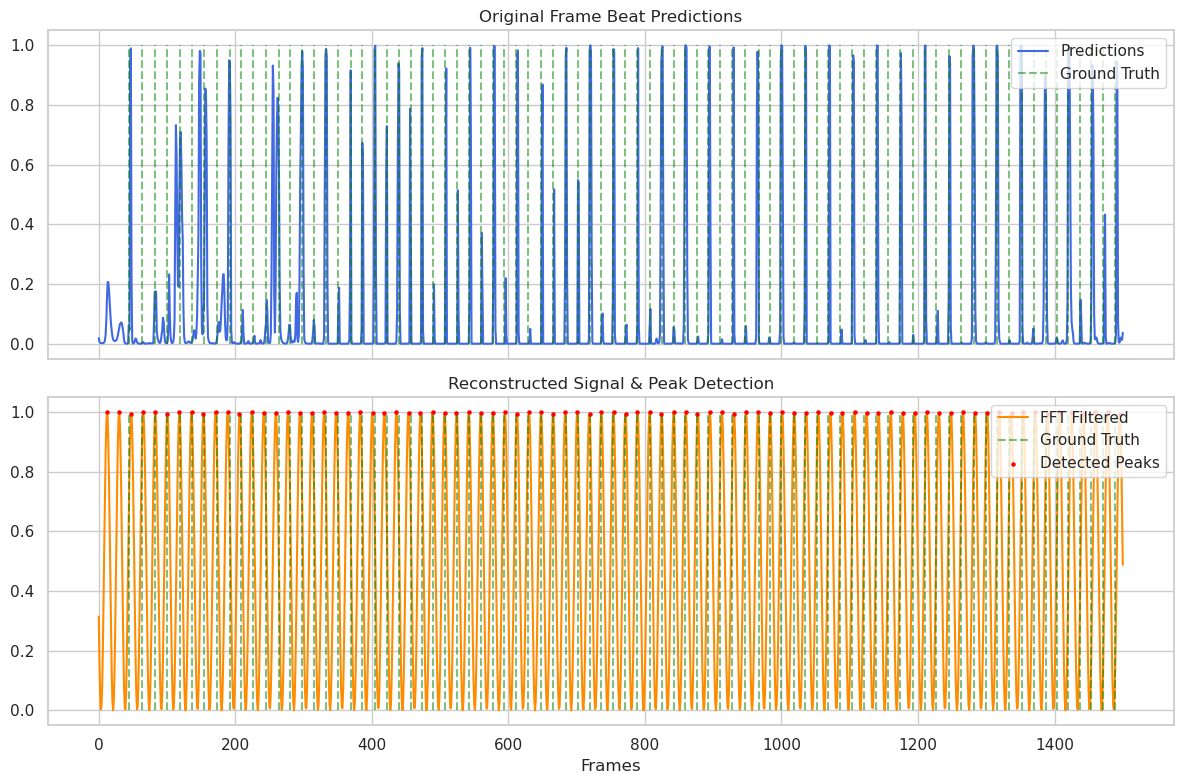

In [189]:
sr = 22050
N = 14
beatPred, dbPred, beatTarget, dbTarget = getBeatPredictions(plModel, datamodule, song_idx = N, plot = False, sum_head = args.get('sum_head', True))

path = datamodule.test_dataset[N]['spect_path']  # pyright: ignore[reportCallIssue, reportArgumentType]
songID = path.split("/")[1][4:]
path = songID + ".wav"
path = dataDir / "../archive/audioFragments" / path
assert path.exists(), f"Path {path} does not exist"

song, origSR = torchaudio.load(path)
if origSR != sr:
    song = T.Resample(orig_freq = origSR, new_freq = sr)(song)
original = np.loadtxt(dataDir / "annotations" / "origAnnotations" / f"{songID}.txt") / 1000
full     = pd.read_csv(dataDir / f"annotations/salsaTest/annotations/beats/song{songID}.beats", sep = "\t", header = None).iloc[:, 0].to_numpy()

_, peaks = findPeaksFFT(beatPred, beatTarget, args['fps'], topN = 1)

magnify = 2
sounds = clicks(frames = peaks[::2], sr = sr)
# sounds = clicks(times = full, sr = sr)
if sounds.shape[0] > song.shape[1]:
    sounds = sounds[:song.shape[1]]
else:
    sounds = np.pad(sounds, (0, song.shape[1] - sounds.shape[0]), 'constant', constant_values = 0)

Audio((magnify * sounds.reshape(1, -1) + song.numpy()), rate = sr)

In [177]:
targets  = np.where(beatTarget)[0]
earliest = targets[0]
latest   = targets[-1]

earliestPred = np.abs(peaks - earliest).argmin()
latestPred   = earliestPred + targets.shape[0]
predsCrop    = peaks[earliestPred:latestPred]

differences = (targets[1:] - predsCrop)
differences#, targets, peaks, predsCrop

array([  8,   5,   3,  -9, -11, -12, -27, -30, -31, -32, -29, -30, -31,
       -30, -28, -28, -30, -30, -29, -30, -29, -28, -28, -29, -31, -30,
       -30, -31, -32, -31, -31, -31, -31, -30, -29, -29, -30, -29, -29,
       -30, -30, -30, -29, -30, -29, -28, -29, -31, -30, -29, -29, -30,
       -31, -31, -32, -33, -34, -33, -33, -34, -35, -34, -15,   3,   2,
         3,   2,   2,   1,   2,   2,   2,   1,   1,   1,   1,   1,   2,
         1,   0,   0,   1,   1,   0,  -1,  -2,   0,  -1,  -2,  -1,  -2])

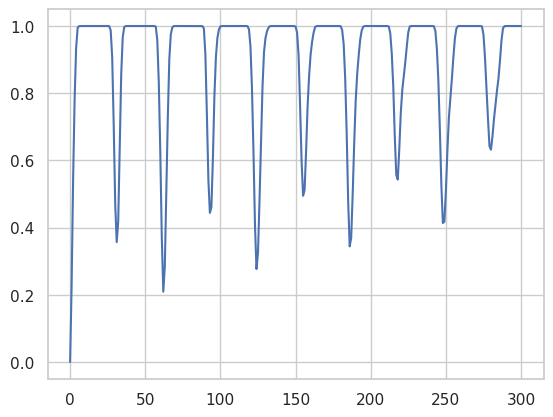

In [166]:
pers = []
for per in range(0, 301):
    if per == 0:
        pers.append(0)
        continue
    x1 = torch.from_numpy(beatPred[:-per])
    x2 = torch.from_numpy(beatPred[per:])

    # Want high correlation (negative loss)
    correlation = torch.nn.functional.cosine_similarity(x1, x2, dim = 0)

    pers.append(1.0 - correlation)

plt.plot(pers)
plt.show()

In [171]:
np.diff(np.where(beatTarget)[0])

array([15, 15, 16, 16, 16, 16, 14, 14, 16, 15, 16, 15, 16, 16, 16, 16, 15,
       15, 15, 15, 17, 16, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 15,
       17, 16, 15, 15, 16, 15, 16, 15, 16, 16, 16, 16, 15, 15, 16, 16, 16,
       16, 15, 14, 15, 16, 16, 16, 15, 15, 16, 16, 34, 34, 15, 16, 15, 16,
       15, 16, 15, 16, 15, 15, 15, 16, 16, 16, 15, 15, 16, 16, 15, 15, 15,
       14, 17, 16, 15, 15, 15])

In [180]:
np.diff(peaks)

array([16, 16, 16, 16, 16, 16, 17, 15, 16, 16, 16, 15, 16, 15, 16, 15, 16,
       15, 16, 15, 16, 15, 15, 16, 15, 16, 15, 15, 16, 15, 16, 15, 15, 16,
       15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 16, 15, 16, 15, 16, 16, 15,
       16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 15,
       16, 15, 16, 16, 15, 16, 15, 16, 16, 15, 16, 15, 16, 16, 15, 16, 15,
       16, 15, 16, 16, 15, 16, 15, 16, 16, 15])